# Alcohol Consumption Prediction

In [166]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 7)

## Introduction
While not the most dangerous, alcohol is one of the most popular drugs in the world. Its consumption is not only popularized but normalized in modern society, regardless of any negative effects it may have. Many mental factors, such as extraversion and neuroticism, can affect how often one consumes alcohol. Neuroticism refers to negative emotions in the long term, such as depression, while extraversion refers to positive emotions and personality. Furthermore, minimum legal ages fail to stop children and young teens from consuming alcohol. The question we aim to answer in this project is **"How can we predict the frequency of alcohol consumption based on certain aspects of an individual’s personality?"** The dataset we are using to answer this question is a quantified drug consumption dataset. The dataset contains information about 1885 unique individuals. Each entry contains 12 attributes such as personality measurements, age, ethnicity, and etc; all of which are quantified and standardized. In addition, the dataset contains information regarding these individuals’ use of 18 drugs, ranging from chocolate to heroin, and one fictitious drug (semeron) to filter out liars. Each value in the drug columns reflects the recency of an individual’s use of a certain drug, ranging from “Never Used” to “Used in Last Day.”

## Preliminary Data Exploration
### Reading the data
The dataset does not contain any headings so we will provide labels for each column and rename appropriately.

In [167]:
drugs_data <- read_csv("data_sets_project/drug_consumption.csv", col_names = FALSE)
colnames(drugs_data) <- c("ID", "Age", "Gender", "Education", "Country", "Ethnicity", "Neuroticism", "Extraversion", 
                          "Openness_to_Experience", "Agreeableness", "Conscientiousness", "Impulsiveness", 
                          "Sensation_Seeing", "Alcohol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke",
                          "Crack", "Ecstacy", "Heorin", "LegalH", "LSD", "Meth", "Mushrooms", "Nicotine", "Semer", "VSA")
drugs_data

Rows: 1885 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X...
dbl (13): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,⋯,Ecstacy,Heorin,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,NA
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,⋯,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,⋯,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,⋯,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,⋯,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,⋯,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,⋯,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0
1888,-0.95197,-0.48246,-0.61113,0.21128,-0.31685,-0.46725,2.12700,1.65653,1.11406,⋯,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL6,CL0,CL2


Each row represents an individual and each column represents an attribute assigned to that individual. Thus, the data is in tidy format as each row corresponds to a single observation, each column a single variable and each cell holds a unique value. 

### Selecting the variables
Since we are trying to predict the frequency of alcohol consumption based on each individual's personality traits, we only need to focus on the columns 'Neuroticism', 'Extraversion', 'Openness_to_Experience', 'Agreeableness', 'Impulsiveness', 'Conscientiousness' and of course 'Alcohol'. We would also like to see how the consumption levels vary across different age categories. So we will also include the column 'Age'.

In [168]:
alcohol_data <- select(drugs_data, Age, Neuroticism,
                       Extraversion, Openness_to_Experience,
                       Agreeableness, Impulsiveness, Conscientiousness, Alcohol, Semer)
alcohol_data

Age,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,Impulsiveness,Conscientiousness,Alcohol,Semer
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.49788,0.31287,-0.57545,-0.58331,-0.91699,-0.21712,-0.00665,CL5,CL2
-0.07854,-0.67825,1.93886,1.43533,0.76096,-0.71126,-0.14277,CL5,CL4
0.49788,-0.46725,0.80523,-0.84732,-1.62090,-1.37983,-1.01450,CL6,CL0
-0.95197,-0.14882,-0.80615,-0.01928,0.59042,-1.37983,0.58489,CL4,CL2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.07854,1.13281,-1.37639,-1.27553,-1.77200,0.52975,-1.38502,CL4,CL6
-0.95197,0.91093,-1.92173,0.29338,-1.62090,1.29221,-2.57309,CL5,CL4
-0.95197,-0.46725,2.12700,1.65653,1.11406,0.88113,0.41594,CL4,CL6


### Filtering out irrelevant observations
We want to get rid of the observations which do not have the value for the variable Semer equal to CL0 (which means Never Used). This is because Semer is a fictitious drug and people who chose any option other than CL0 were ignorant respondents who need to be filtered out.

In [169]:
alcohol_data_filtered <- alcohol_data |>
                         filter(Semer == "CL0") |>
                         select(-Semer)
alcohol_data_filtered

Age,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,Impulsiveness,Conscientiousness,Alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.49788,-0.46725,0.80523,-0.84732,-1.62090,-1.37983,-1.01450,CL6
0.49788,-1.32828,1.93886,-0.84732,-0.30172,0.19268,1.63088,CL5
1.82213,-2.05048,-1.50796,-1.55521,-1.07533,-0.71126,1.13407,CL5
1.82213,1.37297,-0.15487,-0.17779,-1.92595,-0.71126,-1.51840,CL6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.95197,-0.79151,0.00332,2.44904,0.76096,0.88113,-1.51840,CL5
2.59171,2.12700,-0.15487,2.44904,0.94156,-0.21712,-0.65253,CL5
-0.95197,-1.19430,1.74091,1.88511,0.76096,0.88113,-1.13788,CL5


### Summarizing data
We are going to use only training data from this point on for our data exploration. 

In [170]:
alcohol_split <- initial_split(alcohol_data_filtered, prop = 0.75, strata = Alcohol)
alcohol_train <- training(alcohol_split)
alcohol_train

Age,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,Impulsiveness,Conscientiousness,Alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1.82213,0.04257,-0.69509,-1.11902,-0.45321,-1.37983,-0.40581,CL3
2.59171,-0.14882,-0.80615,-0.97631,0.76096,-1.37983,0.41594,CL3
0.49788,-2.21844,0.47617,-1.82919,-0.76096,-1.37983,2.04506,CL3
1.09449,-0.34799,1.93886,0.29338,0.43852,-0.21712,0.58489,CL3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.09449,-0.34799,-1.09207,-0.17779,-0.60633,-0.71126,0.58489,CL6
1.09449,2.28554,-1.23177,-0.01928,-2.53830,-0.21712,-2.90161,CL2
-0.07854,-0.46725,-1.50796,-0.58331,-0.30172,0.52975,-0.40581,CL6


First, we will see how many observations are there for each class of alcohol consumption.

In [171]:
alcohol_count <- group_by(alcohol_train, Alcohol) |>
                 summarize(n = n())
alcohol_count

Alcohol,n
<chr>,<int>
CL0,16
CL1,8
CL2,12
CL3,33
CL4,49
CL5,138
CL6,64


As you can see, most of the individuals belong to the class 'CL6'. To make it more clear, we will rename the classes.

In [172]:
meaning <- c("Never Used", "Used over a Decade Ago", "Used in Last Decade",
             "Used in Last Year", "Used in Last Month", "Used in Last Week", "Used in Last Day")
alcohol_count_meaning <- bind_cols(meaning, alcohol_count)
colnames(alcohol_count_meaning) <- c("Meaning", "Class", "No. of Individuals")
alcohol_count_meaning

New names:
• `` -> `...1`


Meaning,Class,No. of Individuals
<chr>,<chr>,<int>
Never Used,CL0,16
Used over a Decade Ago,CL1,8
Used in Last Decade,CL2,12
Used in Last Year,CL3,33
Used in Last Month,CL4,49
Used in Last Week,CL5,138
Used in Last Day,CL6,64


Thus, most of the individuals consumed alcohol in the last week. 

We also want find out the number of individuals in each of the age group categories.

In [173]:
age_count <- group_by(alcohol_train, Age) |>
                 summarize(n = n()) |>
                bind_cols(c("18-24", "25-34", "35-44", "45-54", "55-64", "65+"))
colnames(age_count) <- c("Age", "No. of Individuals", "Age Group")
age_count

New names:
• `` -> `...3`


Age,No. of Individuals,Age Group
<dbl>,<int>,<chr>
-0.95197,74,18-24
-0.07854,87,25-34
0.49788,61,35-44
1.09449,78,45-54
1.82213,15,55-64
2.59171,5,65+


There is an unequal distribution of participants among different age groups.

Now, we will find out the mean for each of the personality attributes. However, the values for the attributes in the data set do not reflect their true values probably because they have been standarized. So we will provide the closest true values when we find out the means for these variables except for the variable 'Impulsiveness' because only the standardized values have been provided for it in the data set information page.

In [174]:
attributes_mean <- alcohol_train |>
                   select(Neuroticism:Conscientiousness) |>
                   map_dfc(mean) |>
                   pivot_longer(cols = Neuroticism:Conscientiousness,
                               names_to = "Personality Trait",
                               values_to = "Mean") |>
                   bind_cols(c("36", "41", "47", "43", "NA", "42"),
                             c("12-60", "16-59", "24-60", "12-60", "NA", "17-59"))
colnames(attributes_mean) <- c("Personality Trait", "Mean", "Closest True Value", "Range of True Values")
attributes_mean

New names:
• `` -> `...3`
• `` -> `...4`


Personality Trait,Mean,Closest True Value,Range of True Values
<chr>,<dbl>,<chr>,<chr>
Neuroticism,-0.16716491,36,12-60
Extraversion,0.05937525,41,16-59
Openness_to_Experience,-0.34629066,47,24-60
Agreeableness,0.18742122,43,12-60
Impulsiveness,-0.36506100,NA,NA
Conscientiousness,0.32312497,42,17-59


### Visualizing the data
We want to find out the distribution of alcohol consumption among individuals across different age categories. We will do this using a bar chart.

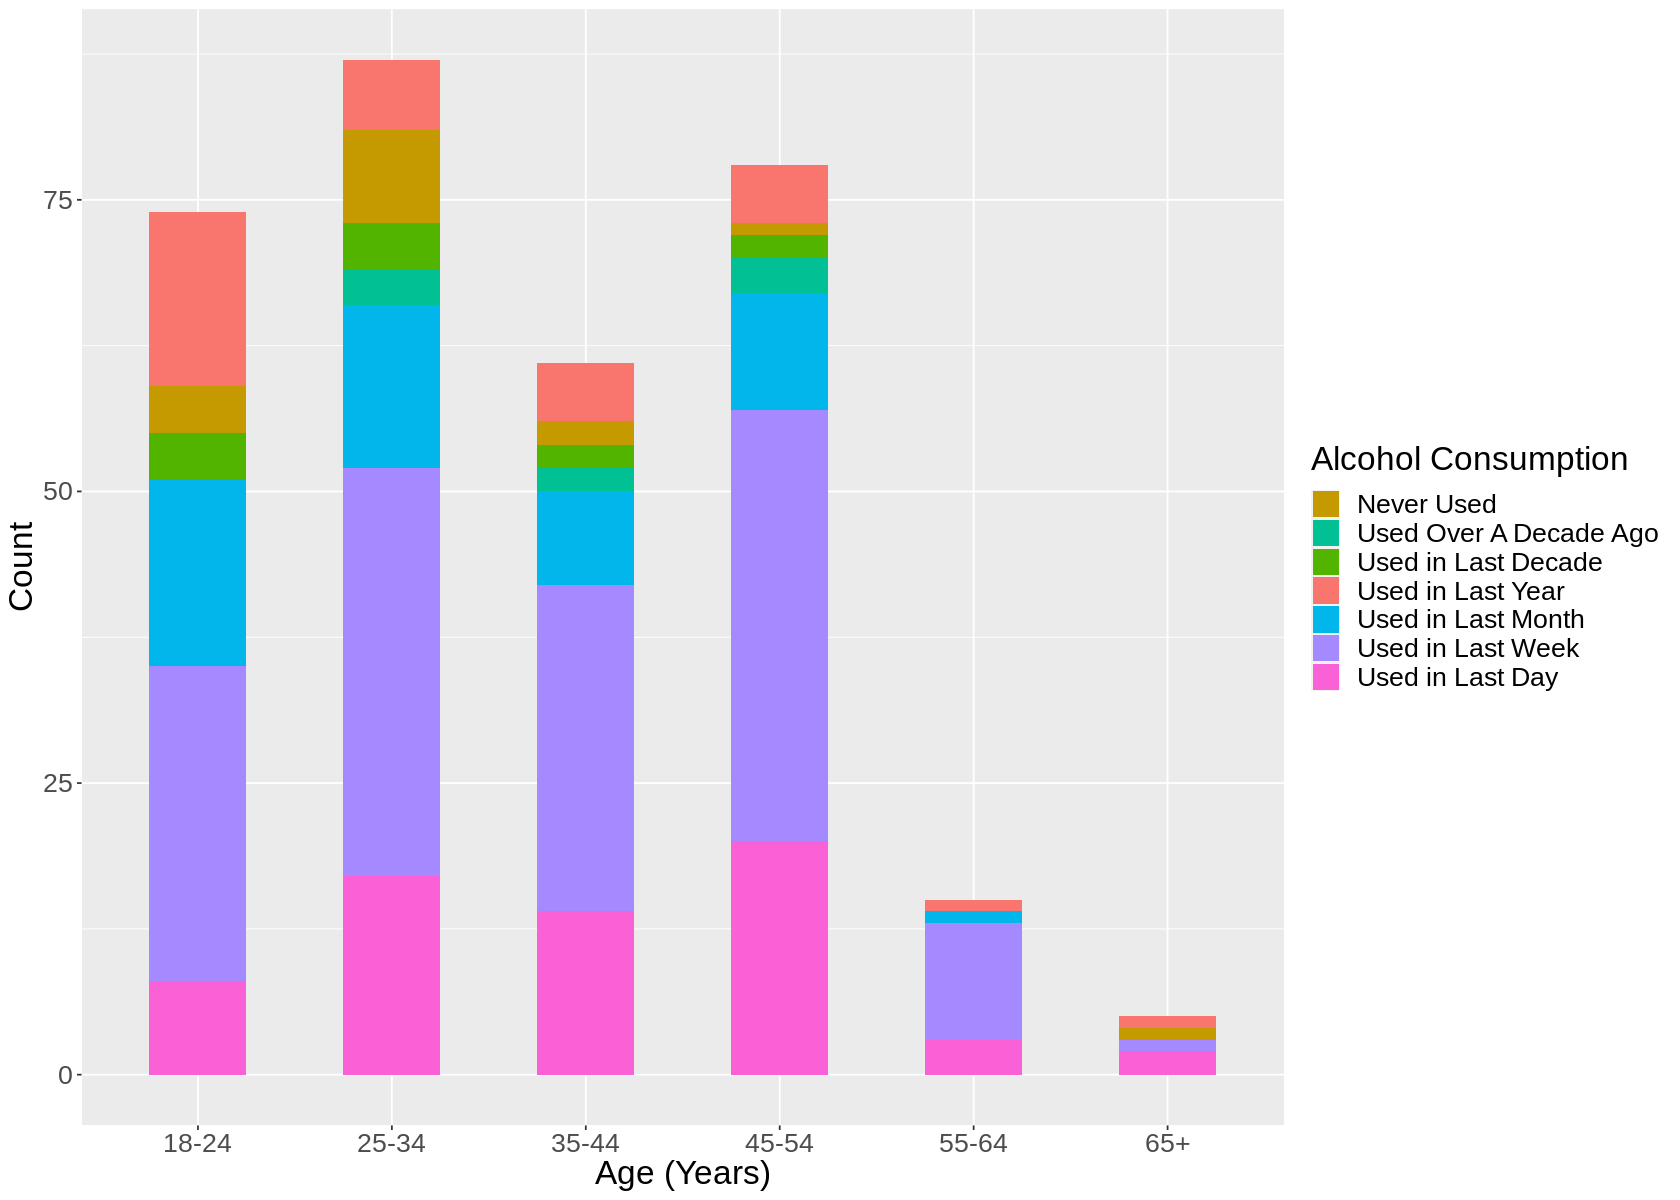

In [175]:
options(repr.plot.width = 14, repr.plot.height = 10)
alcohol_plot_age <- ggplot(alcohol_train, aes(x = as_factor(Age), fill = as_factor(Alcohol))) +
  geom_bar(width = 0.5) +
theme(text = element_text(size = 20)) + 
        scale_x_discrete(breaks = c("2.59171", "1.82213", "1.09449", "0.49788", "-0.07854", "-0.95197"),
                   labels = c("65+", "55-64", "45-54", "35-44", "25-34", "18-24")) +
scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                   labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                              "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
                labs(x = "Age (Years)", y = "Count", fill = "Alcohol Consumption")
alcohol_plot_age

Looking at the plot, we can see that highest number of individuals consumed alcohol in the last week and the second highest number of individuals consumed alcohol in the last day across all age groups. On the other hand, the lowest number of individuals consumed alcohol over a decade ago.

Now we will find out the distribution of scores for different personality attributes among all individuals and split the result based on alcohol consumption levels using a histogram.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



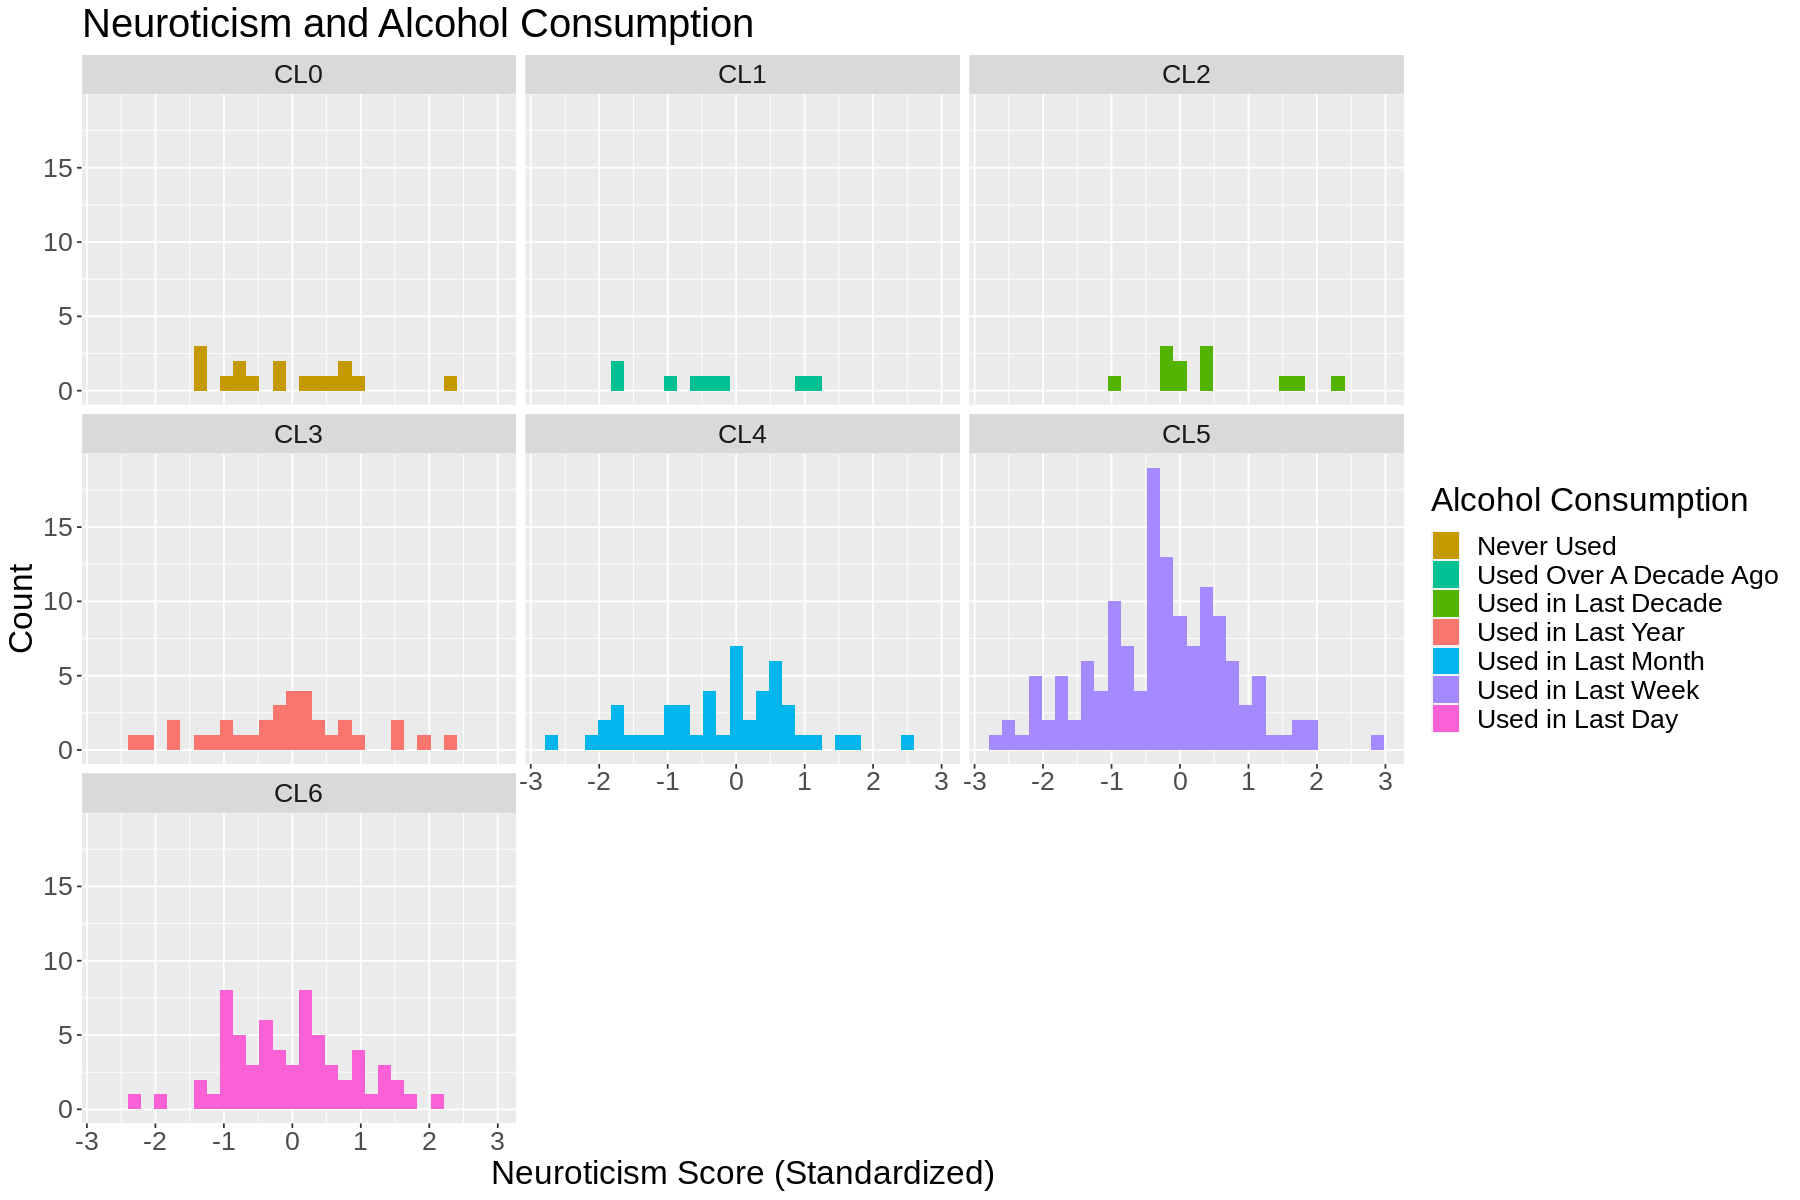

In [176]:
options(repr.plot.width = 15, repr.plot.height = 10)
nscore <- ggplot(alcohol_train, aes(x = Neuroticism, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Neuroticism Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Neuroticism and Alcohol Consumption") +
          theme(text = element_text(size = 20))

nscore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



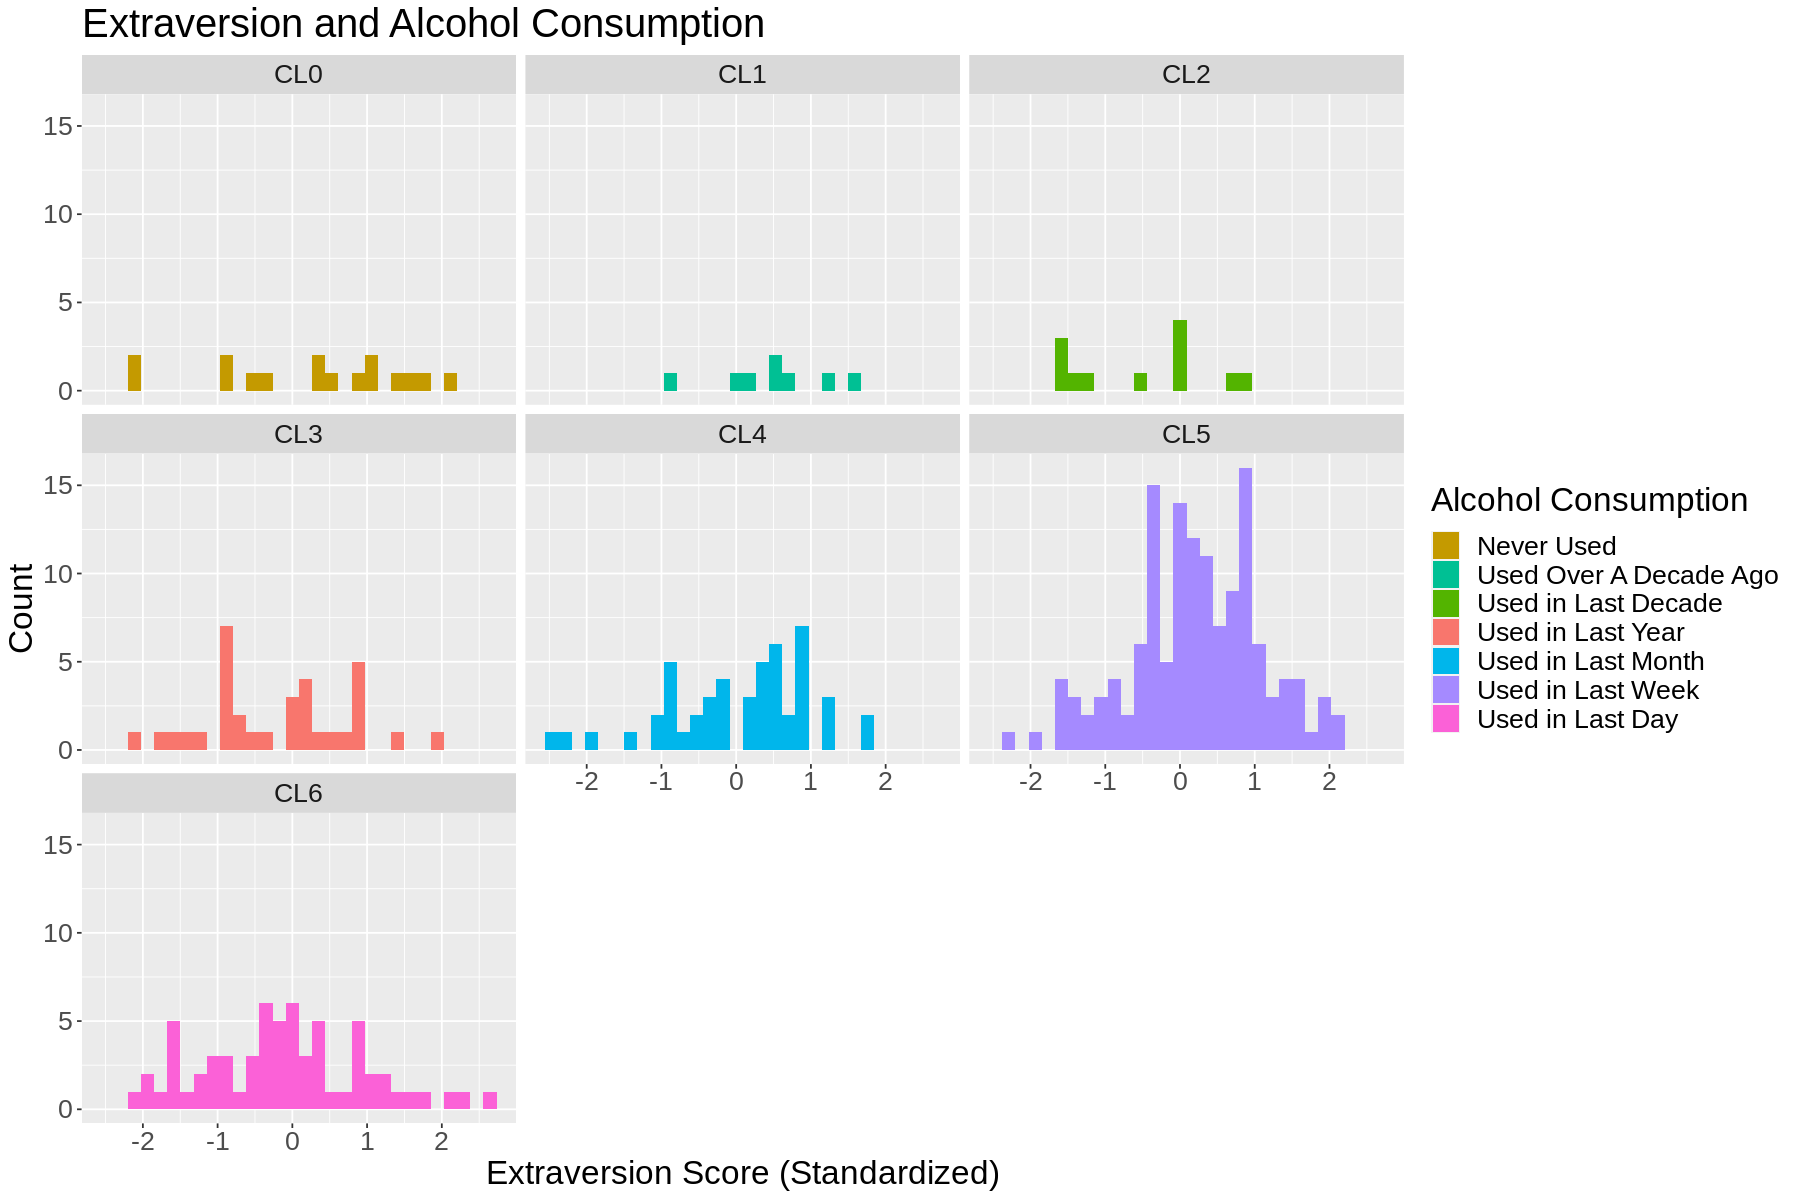

In [177]:
escore <- ggplot(alcohol_train, aes(x = Extraversion, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Extraversion Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Extraversion and Alcohol Consumption") +
          theme(text = element_text(size = 20))

escore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



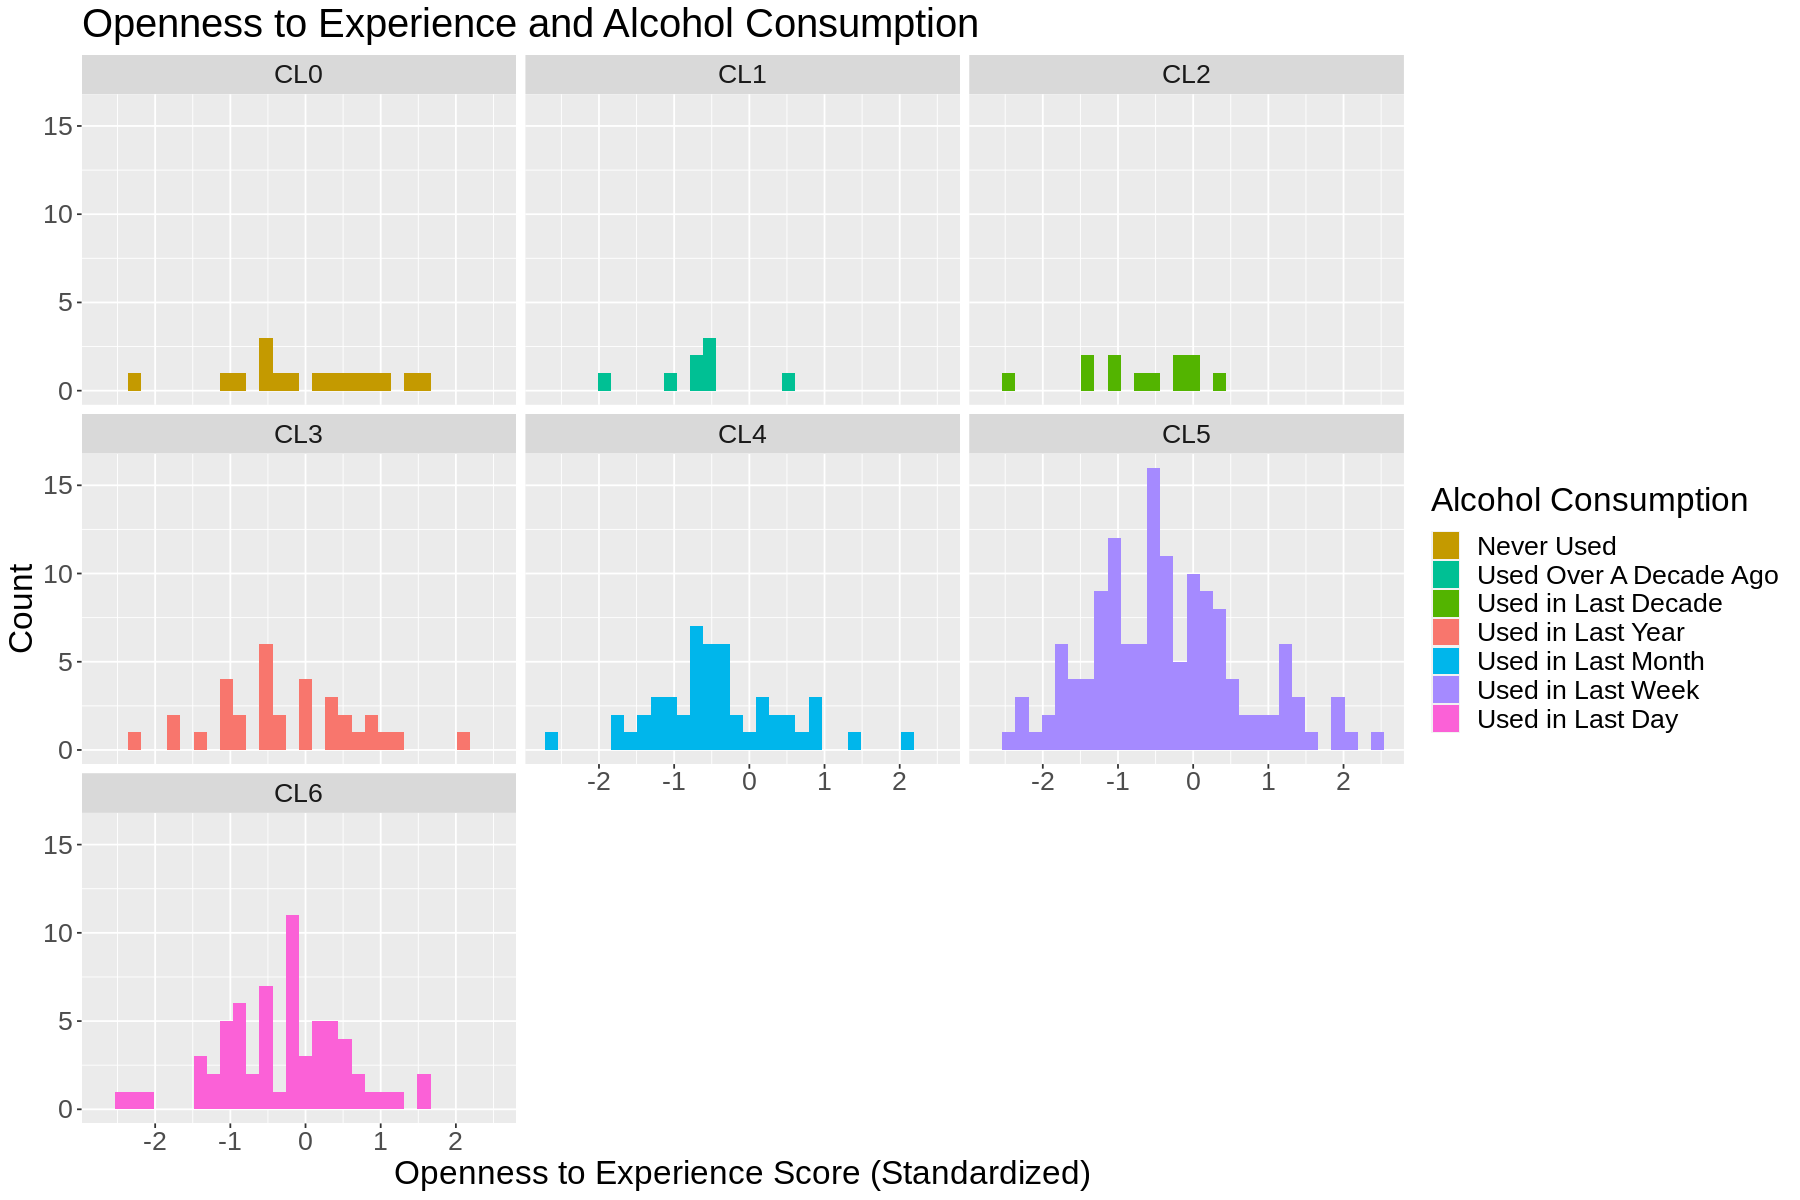

In [178]:
oscore <- ggplot(alcohol_train, aes(x = Openness_to_Experience, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Openness to Experience Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Openness to Experience and Alcohol Consumption") +
          theme(text = element_text(size = 20))

oscore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



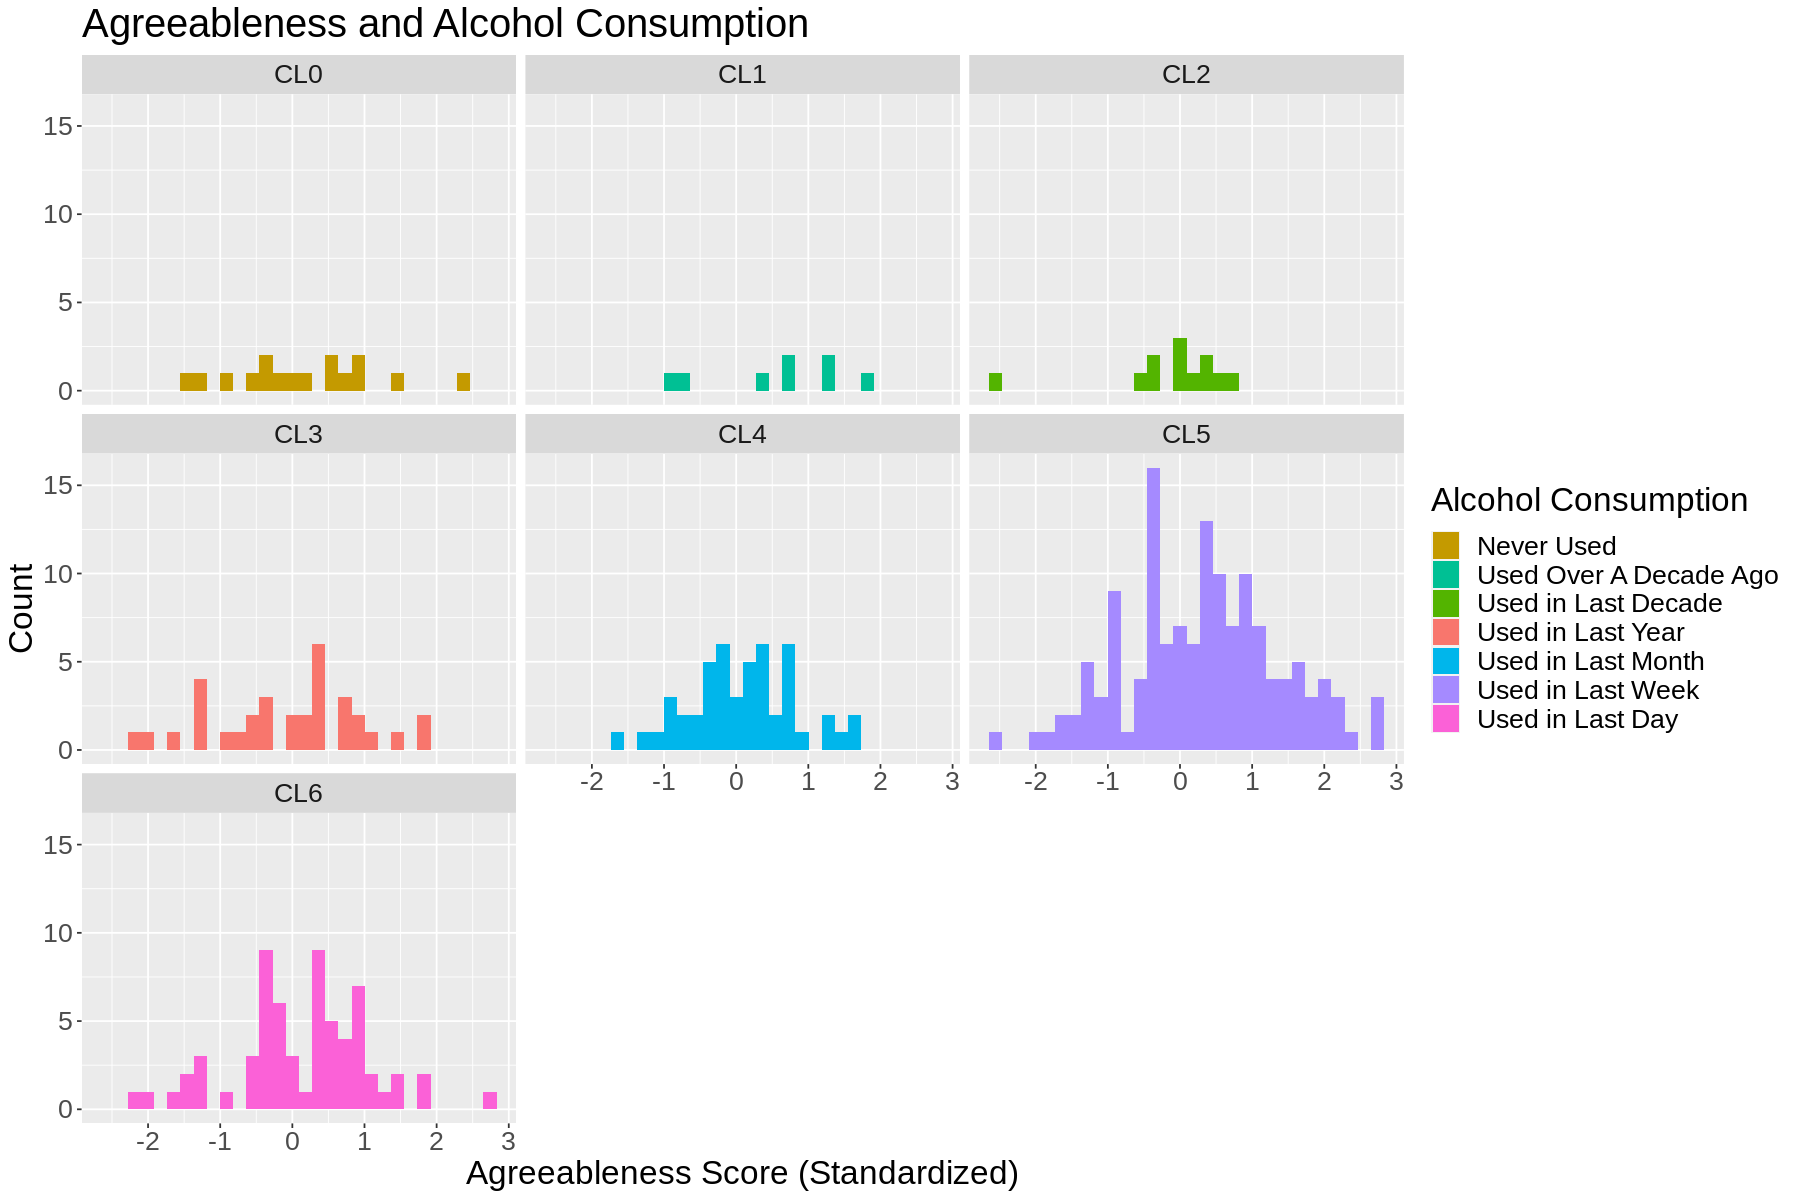

In [179]:
ascore <- ggplot(alcohol_train, aes(x = Agreeableness, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Agreeableness Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Agreeableness and Alcohol Consumption") +
          theme(text = element_text(size = 20))

ascore

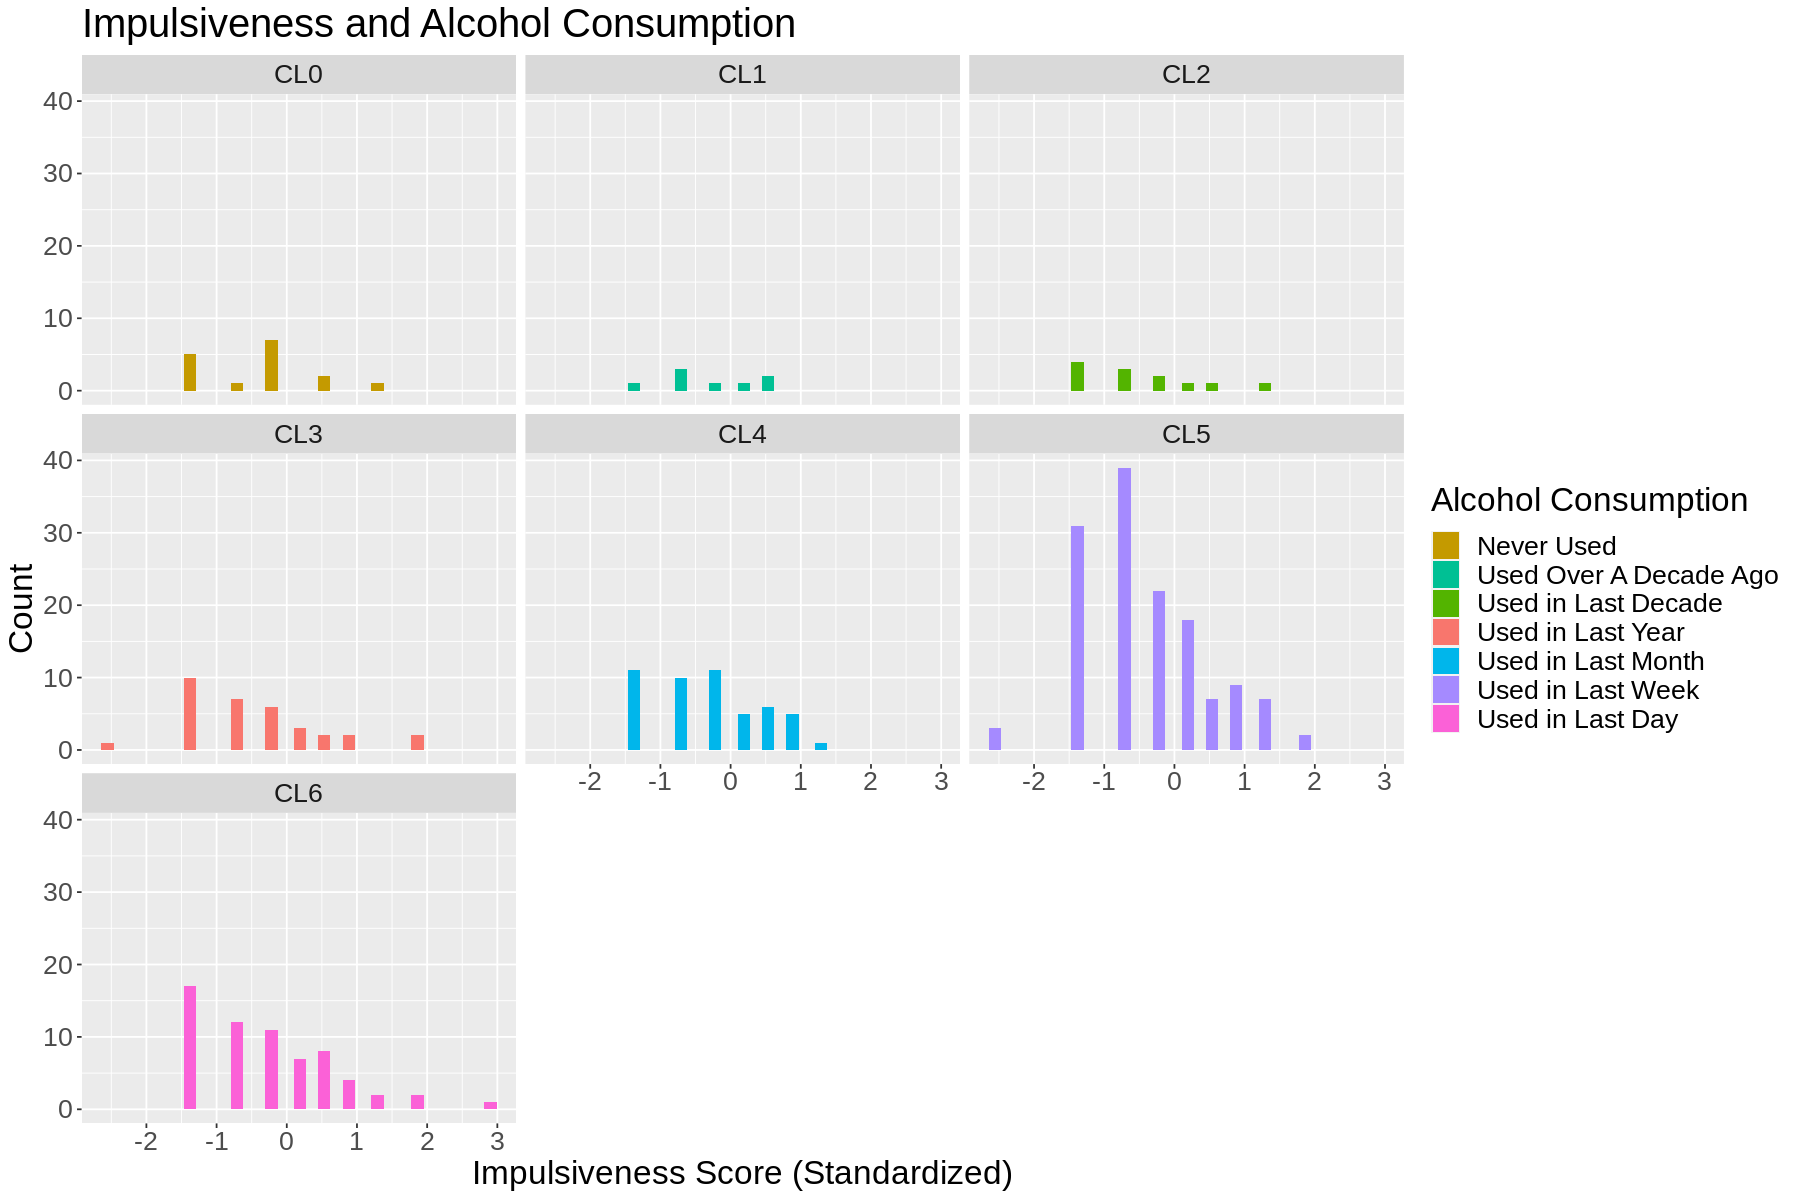

In [180]:
iscore <- ggplot(alcohol_train, aes(x = Impulsiveness, fill = as_factor(Alcohol))) +
          geom_bar() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Impulsiveness Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Impulsiveness and Alcohol Consumption") +
          theme(text = element_text(size = 20))

iscore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



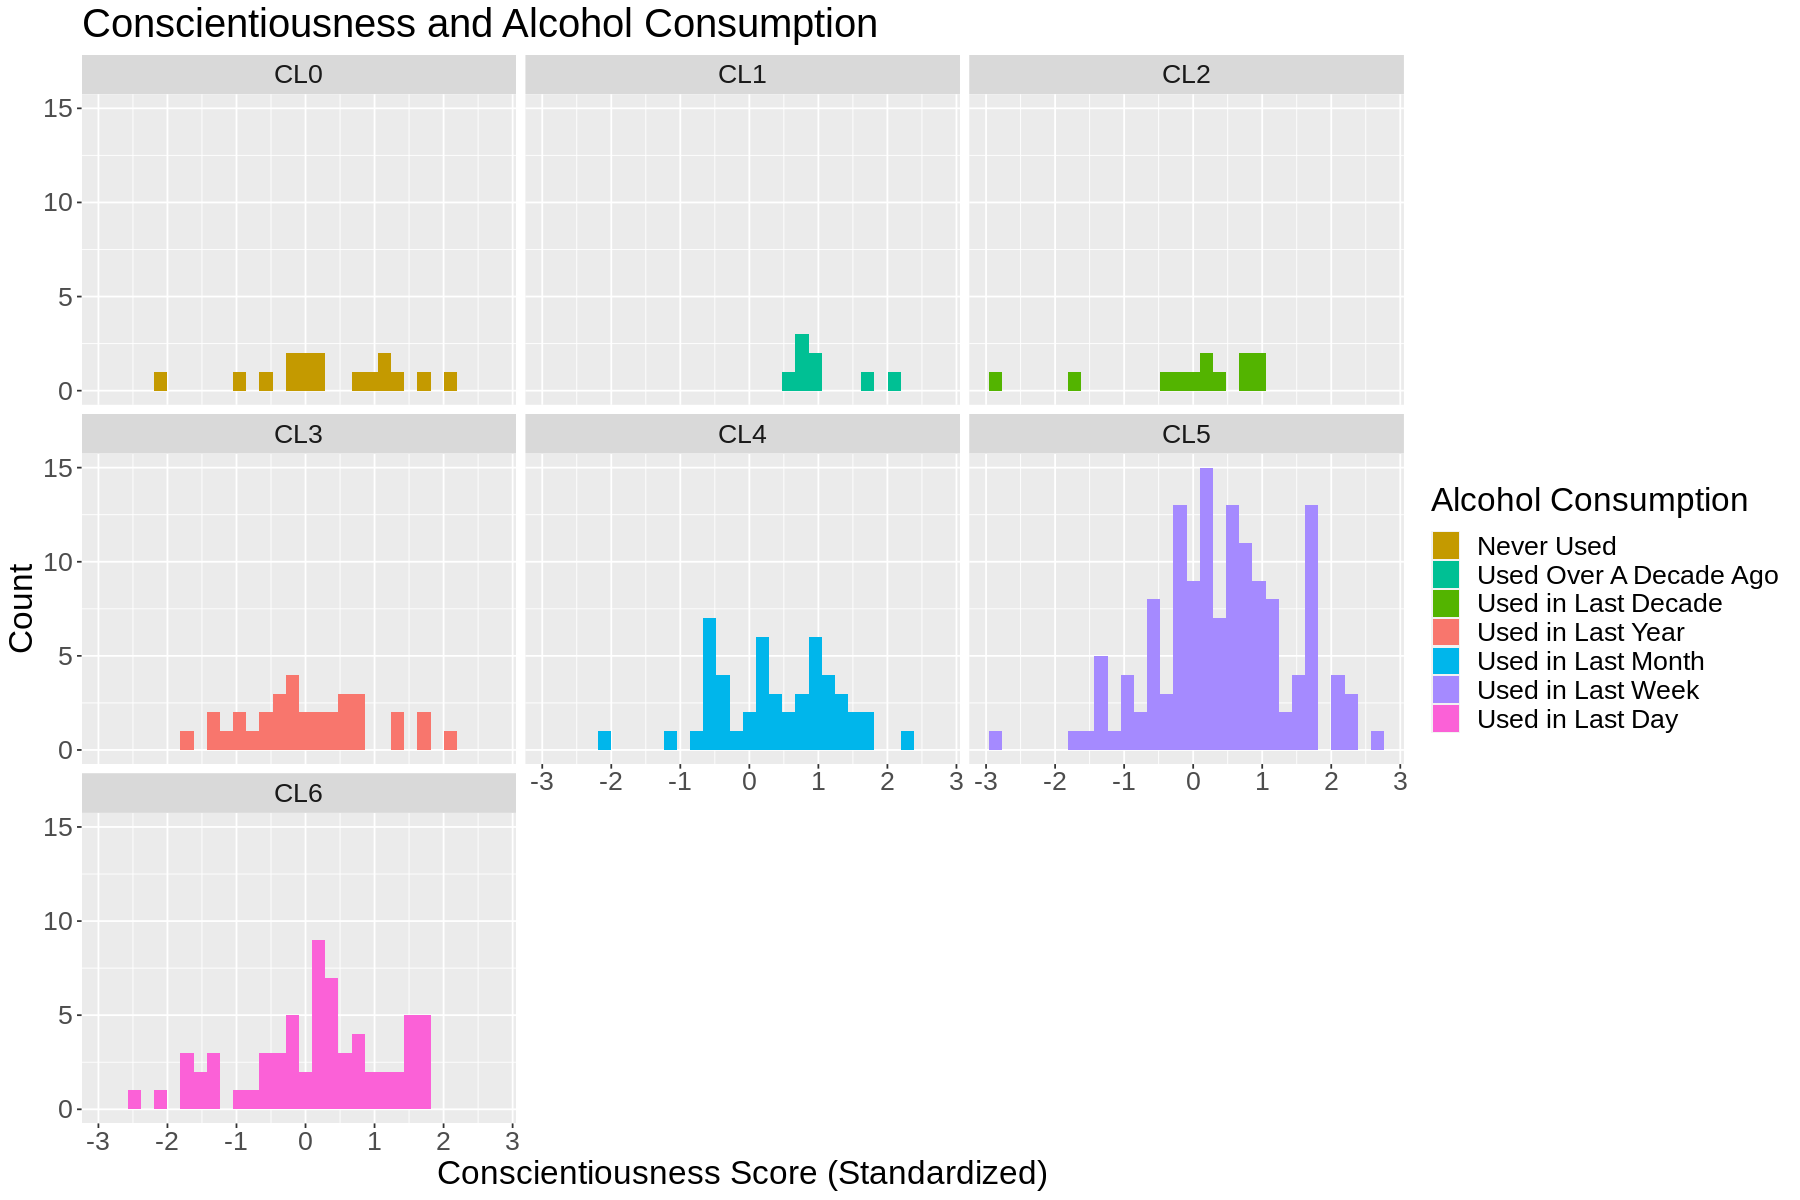

In [181]:
cscore <- ggplot(alcohol_train, aes(x = Conscientiousness, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Conscientiousness Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Conscientiousness and Alcohol Consumption") +
          theme(text = element_text(size = 20))

cscore

## Methods:

The columns we are using for the analysis are `Age`, `Alcohol`, `EScore`, and `NScore`. `EScore` and `NScore` represent extraversion and neuroticism respectively and the analysis we are conducting is classification. The end goal of the project is to be able to input an `NScore`, `EScore`, and `Age` value into a created classification workflow and receive a predicted consumption. Firstly, we will standardize the data using `step_scale()` and `step_center()`. Next, we’ll create a recipe to use `NScore`, `EScore` and `Age` as predictors and set `Alcohol` as our target variable. We will then create a workflow using the kknn engine, a rectangular weight function, and the optimal number of neighbours determined from five-fold cross-validation. We will use this workflow to make the predictions, and visualize them with a bar graph.

In our graph, each class on the x-axis will have two vertical bars which will represent the count of its class in the test data. With two bars side by side for each class, the right side will be the true count of the class inside the test data while the left side will represent the number of times the class appeared when we predicted the entire test data with our classifier. This visualization is effective as it makes it easy to deduce the accuracy of our model. The closer in heights the two bars are, the more accurate it is for that specific class.

## Expected Outcomes and Significance:

Through our analysis, we expect to find a correlation between neuroticism, extroversion, age, and alcohol consumption. We also expect to find a spike in consumption the closer one becomes to the legal age, and a slow decline in usage afterwards. By finding the correlation, alcohol prevention programs can better target individuals who match the traits of a high alcohol consumer. Conversely, advertisements by alcohol companies can also better target these individuals to boost sales. Ultimately, our outcome could lead to many future questions, most significantly, why these variables affect the consumption of alcohol and could help obtain a much better understanding of the drug. 


## References
UCI Machine Learning Repository: Drug consumption (quantified) Data Set. (n.d.). Retrieved October 29, 2022, from https://archive.ics.uci.edu/ml/datasets/Drug+consumption+(quantified)

Campbell, T., Timbers, T., & Lee, M. (2022). Data Science: A First Introduction (1st ed.). CRC Press. https://datasciencebook.ca/about-the-authors.html
